#### cycleGAN to transform between masks and widefield microscope images

#### input: images: (t, H, W, C) | masks: (t, H, W, C). Outputs: (t, H, W, C). C=3

In [127]:
# detect the GPU status

import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

2.6.2
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32503955456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13380019599855846752
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0"



2022-06-24 10:25:46.846710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


[None]

In [128]:
# define if the documenting process should go on

DOCUMENT = False
TRAIN = 500 # training epochs num

In [129]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-GAN",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "CycleGAN_vanilla",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training

    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["vanilla", "val", "binary", "epochs:300"])


#### Load in the data

In [130]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

In [131]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [132]:
# # preprocess the data: resize, adding channel, and rescale into [a1, a2]
# # imgStack: mask with 0,1

# from skimage.transform import resize

# def pre_process(imgStack, maskStack, CHANNEL, bound = [a1,a2]):
    

In [133]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)

Mask = Mask[...,176:(176+Mask.shape[1])]  # crop for later scaling
IMG = IMG[...,176:(176+IMG.shape[1])]

print('Mask info: ', Mask.shape, Mask.dtype)
print('Image info: ', IMG.shape, IMG.dtype)

Mask info:  (300, 1040, 1040) uint8
Image info:  (300, 1040, 1040) uint8


In [134]:
# resize the images

from skimage.transform import resize

SIZE = [256, 256]
totalIMG = Mask.shape[0]
numIMG = 250

smallIMG = resize(IMG[:numIMG,...], (numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)
smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (-1, 1))  # rescale the img into [-1, 1] for cycleGAN

smallMask = resize(Mask[:numIMG,...].astype(bool), (numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
smallMask = smallMask.astype(int)
smallMask = np.interp(smallMask, (smallMask.min(), smallMask.max()), (-1, 1))

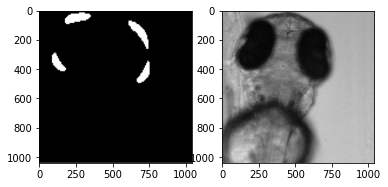

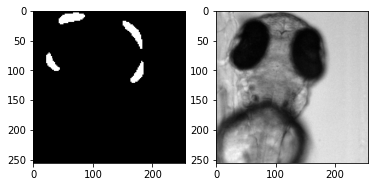

In [135]:
# sanity check

NUM = 100

subShow(Mask[NUM,...], IMG[NUM,...])

subShow(smallMask[NUM,...], smallIMG[NUM,...])

In [136]:
# patchify the images
from patchify import patchify, unpatchify

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

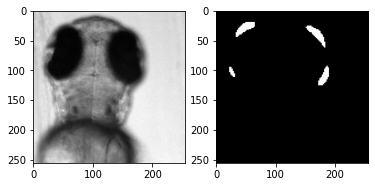

img: (250, 256, 256) float64
mask: (250, 256, 256) float64
img range: 1.0 -1.0
mask range: 1.0 -1.0


In [137]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [138]:
# preporcessing the data into patches and change into 3 channels

# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.stack((Y_masks,)*3, axis=-1) #Y_masks = np.expand_dims(Y_masks, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img: (250, 256, 256, 3)
masks: (250, 256, 256, 3)


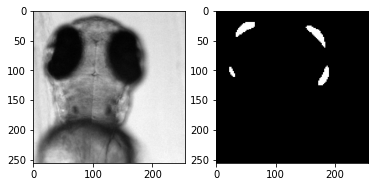

In [139]:
# sanity check on one layer
print('img:', X_patches.shape)
print('masks:', Y_masks.shape)

subShow(X_patches[0,:,:,0], Y_masks[0,...])

In [140]:
# check the data properties

print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

patches shape: (250, 256, 256, 3) float64
mask shape: (250, 256, 256, 3) float64
1.0 -1.0
-0.18901383526725068 -0.9941123068768966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


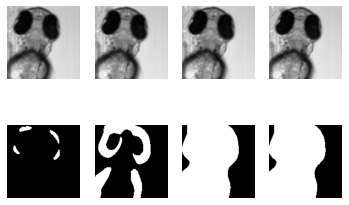

In [141]:
#  sanity check for the mask and images

startNum = 100
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_patches[int(i+startNum),:,:,0], cmap='gray')  # only visualize one channel
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_masks[int(i+startNum)], cmap='gray')    
plt.show()

#### Prepare the model

In [142]:
from random import random
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow.keras as k

# use instance normalization as suggested in paper
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import matplotlib.pyplot as plt

# use the spectral normalization
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

#### Discriminator. 70x70 patch GAN

In [143]:
# C64-C128-C256-C512
# After last layer, conv to 1-dimension then go through sigmoid
# axis of instancenorm is '-1', ensure features are normalized per feature map

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = k.layers.Input(shape=image_shape)
    
    #C64: 4x4 kernel, strides 2x2
    # d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    conv1 = SpectralNormalization(k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    d = conv1(in_image)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # C128: 4x4 kernel, strides 2x2
    # d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    conv2 = SpectralNormalization(k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    d = conv2(d)
    d = InstanceNormalization(axis=-1)(d) # first norm then activate
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # C256: 4x4 kernel, strides 2x2
    # d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    conv3 = SpectralNormalization(k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    d = conv3(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # C512: 4x4 kernel, stride 2x2
    # DIY layer,not in original paper
    # d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    conv4 = SpectralNormalization(k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    d = conv4(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. kernel 4x4, but stride 1x1
    # d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    conv5 = SpectralNormalization(k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init))
    d = conv5(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # patch output
    # patch_out = k.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    conv6 = SpectralNormalization(k.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=init))
    patch_out = conv6(d)
    # patch_out = SpectralNormalization(k.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=init))(d)
    
    # define model
    model = k.models.Model(in_image, patch_out)
    # compile the model
    # batch size is 1, Adam as opt.
    # loss of D is weighted by 50% of each update. This slows down D's change to G during training
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, loss_weights=[0.5]) # !!! loss_weights is plural
    return model
    

#### Generator. based on resnet

In [144]:
# residual blocks contain two 3x3 Conv with same number of filters in layers

# to release the gradient vanishing and exploding
def resnet_block(n_filters, input_layer):
    # weight init
    init = RandomNormal(stddev=0.02)
    # first conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
#     g = k.layers.ReLU()(g)
    g = k.layers.Activation('relu')(g)  # ??? to layers.ReLU. 只有leaky直接调用，其他的用activation调用
    # second conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # merge channels with input-layer
    g = k.layers.Concatenate()([g, input_layer])
    return g

In [145]:
# define G model: unet same structure

# c7s1-k: 7x7 Conv -stride 1 -Instancenorm-ReLU -k filters
# dk: 3x3 conv -stride 2 -Instancenorm-ReLU -k filters
# Rk: residual block that contains two 3x3 conv layers
# uk: 3x3 fractional~strided~conv -stride 1/2 -Instancenorm -ReLU -k filters

# two possible structures:
# with 6 res-blocks: c7s1-64, d128, d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3
# with 9 res-blocks: c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape)
    
    # c7s1-64
    g = k.layers.Conv2D(64, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d128
    g = k.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d256
    g = k.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)  # !!! generate the resnet
    # u128
    g = k.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # u64
    g = k.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # c7s1-3
    g = k.layers.Conv2D(3, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = k.layers.Activation('tanh')(g)
    # define the model
    model = k.models.Model(in_image, out_image)  # generator does not compile
    return model

In [146]:
# define a composite model to update generator wuth adversarial and cycle loss
# only use to train generator
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # use this to train both generators. But one at a time
    # trained G is tranable, others are constant
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = k.layers.Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    ouput_d = d_model(gen1_out)
    # identity loss
    input_id = k.layers.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle-loss forward
    output_f = g_model_2(gen1_out)
    # cycle-loss backward
    gen2_out = g_model_2(input_id)  # ???
    output_b = g_model_1(gen2_out)
    
    # define the model graph
    model = k.models.Model([input_gen, input_id], [ouput_d, output_id, output_f, output_b])
    
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1,5,10,10], optimizer=opt) # hyper param from paper
    return model


#### processing images

In [147]:
# load and prepare traning images
# in cycleGAN scale between -1 and 1, last layer is tanh activation

def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1-127.5)/127.5
    X2 = (X2-127.5)/127.5
    return [X1, X2]

# D needs fake and real images
# select batch of samples, return images and target.
# real images the label is '1'
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # generate the 'real' class label
    y = np.ones((n_samples, patch_shape, patch_shape, 1)) # in th same size of one channel
    return X, y

# fake images with label '0'
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# save model
def save_models(PATH, step, g_model_AtoB, g_model_BtoA):
    # save the first generator models
    filename1 = PATH + 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = PATH + 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))  

In [148]:
# predict images with save model, plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # sample input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale pixels from [-1,1] to [0,1]
    X_in = (X_in + 1)/2
    X_out = (X_out + 1)/2
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i+n_samples)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig('./cycleGAN/IMG/' + filename1)
    plt.close()
        

In [149]:
# from random import random
# test = random()
# print(test)

In [150]:
# update fake images pool to avoid model oscillation
# update D using a history of generated images rather than latest generators
# image buffer is 50

from random import random

def update_image_pool(pool, images, max_size=20):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
        # elif random.random() < 0.5:  # weird, must indicate the package name
            # use images, but don't add it into pool
            selected.append(image)
        else:
            # replace exiting images and use replaced 
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    out = np.asarray(selected)  # transfer into array
    return out

#### training process

In [151]:
# train cyclegan
def train(savePATH, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
    # save the training information
    loss_all = []
    # training hyper param
    n_epochs, n_batch = epochs, 1 # batch_size is fixed into 1
    # output square shape of D
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # image pool for fake images
    poolA, poolB = list(), list()
    # number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # training iterations
    n_steps = bat_per_epo * n_epochs
    
    # enumerate epochs
    for i in range(n_steps):
        # for every iteration/ batch
        # sample real images from both domain
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        # generate fake images for both (A2B, B2A)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update the fake images in the pool as buffer with 50 images
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update G-B2A via composite model
        # this is the combine model: G1 + G2 + D
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update D for A->[real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)  # since batch is 1, cannot split into half for real/fale
        
        # update G-A2B via composite model
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # collect the loss information
        loss_all.append([dA_loss1, dA_loss2, g_loss1, dB_loss1, dB_loss2, g_loss2])
        
        # summarize the performance
        # batch size is 1, iteration is same as dataset
        # if there are 100 images, then 1 epoch will be 100 iterations
        print('Iterations>%d, dA[%.3f, %3.f] dB[%.3f,%.3f] g[%.3f, %.3f]'% (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
        
        # evaluate performance periodically
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'A2B')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'B2A')
        
        # save model every 5 batches
        # if (i+1) % (bat_per_epo * 1) == 0:
        if (i+1) % (bat_per_epo * 5) == 0:
            # if batch size(total images)=100, model saved after every 75th * 5 = 375 iter 
            # save_models(i, './cycleGAN/model/' + g_model_AtoB, './cycleGAN/model/' + g_model_BtoA)
            save_models(savePATH, i, g_model_AtoB, g_model_BtoA)
            
    np.save('./cycleGAN/cycleGAN_500.npy', np.asarray(loss_all))
            

#### prepare the data

In [152]:
from os import listdir
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# the data has been rescaled into [-1, 1]
images = X_patches
masks = Y_masks
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


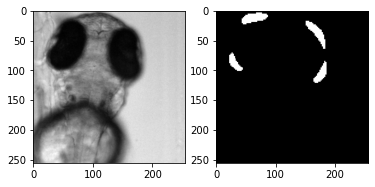

(187, 256, 256, 3) (187, 256, 256, 3)


In [153]:
# sanity check for the data

NUM = 100

subShow(images[NUM,:,:,0], masks[NUM,...])

print(X_train.shape, Y_train.shape)

In [154]:
# image pre-processing

dataset = [X_train, Y_train]  # single channel

print('processed: ', dataset[0].shape, dataset[1].shape)

processed:  (187, 256, 256, 3) (187, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


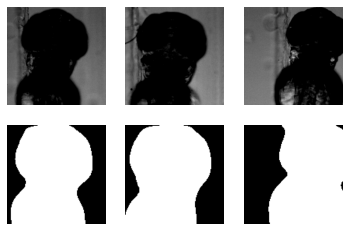

In [155]:
# sanity check
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.axis('off')
    plt.imshow(dataset[0][i])
    
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1+n_samples)
    plt.axis('off')
    plt.imshow(dataset[1][i])
plt.show()

In [156]:
image_shape = dataset[0].shape[1:]

In [157]:
# define hyper param and intance of model in cycleGAN
image_shape = dataset[0].shape[1:]
# generator A->B
g_model_AtoB = define_generator(image_shape)
# generator B->A
g_model_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_model_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Training process

In [ ]:
# training

from datetime import datetime
start1 = datetime.now()

# train model
savePATH = './cycleGAN/model/'
# train(savePATH, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1)
train(savePATH, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=TRAIN)

stop1 = datetime.now()

2022-06-24 10:26:07.080876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-24 10:26:08.083828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


Iterations>1, dA[0.368,   1] dB[0.529,0.729] g[22.689, 21.409]
Iterations>2, dA[10.315,   4] dB[2.121,2.866] g[25.339, 23.398]
Iterations>3, dA[3.989,   4] dB[3.338,3.860] g[30.276, 20.220]
Iterations>4, dA[2.557,   7] dB[8.204,3.272] g[20.766, 22.539]
Iterations>5, dA[2.261,   2] dB[3.671,2.409] g[18.081, 16.530]
Iterations>6, dA[0.991,   1] dB[0.699,0.709] g[15.342, 13.846]
Iterations>7, dA[0.250,   0] dB[0.224,0.231] g[12.521, 11.765]
Iterations>8, dA[0.124,   0] dB[0.161,0.157] g[10.797, 10.023]
Iterations>9, dA[0.142,   0] dB[0.138,0.142] g[9.396, 8.862]
Iterations>10, dA[0.128,   0] dB[0.112,0.119] g[9.189, 8.524]
Iterations>11, dA[0.102,   0] dB[0.122,0.118] g[8.335, 7.263]
Iterations>12, dA[0.193,   0] dB[0.155,0.155] g[9.742, 10.423]
Iterations>13, dA[0.161,   0] dB[0.143,0.122] g[8.323, 8.001]
Iterations>14, dA[0.145,   0] dB[0.115,0.120] g[7.555, 6.457]
Iterations>15, dA[0.137,   0] dB[0.111,0.112] g[7.835, 7.154]
Iterations>16, dA[0.086,   0] dB[0.090,0.067] g[7.820, 7.208]

2022-06-24 10:55:50.951585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-06-24 10:55:50.968943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Iterations>2410, dA[0.038,   0] dB[0.123,0.060] g[6.134, 7.192]
Iterations>2411, dA[0.028,   0] dB[0.045,0.107] g[3.595, 3.617]
Iterations>2412, dA[0.041,   0] dB[0.050,0.099] g[3.398, 3.502]
Iterations>2413, dA[0.026,   0] dB[0.075,0.062] g[7.262, 9.047]
Iterations>2414, dA[0.018,   0] dB[0.256,0.089] g[4.405, 3.385]
Iterations>2415, dA[0.076,   0] dB[0.032,0.078] g[3.196, 3.320]
Iterations>2416, dA[0.052,   0] dB[0.054,0.019] g[7.869, 9.748]
Iterations>2417, dA[0.057,   0] dB[0.053,0.109] g[6.672, 8.256]
Iterations>2418, dA[0.023,   0] dB[0.104,0.080] g[5.727, 4.711]
Iterations>2419, dA[0.039,   0] dB[0.070,0.057] g[8.498, 6.528]
Iterations>2420, dA[0.173,   0] dB[0.045,0.074] g[7.330, 9.004]
Iterations>2421, dA[0.333,   0] dB[0.044,0.107] g[4.621, 4.241]
Iterations>2422, dA[0.070,   0] dB[0.043,0.045] g[14.187, 10.117]
Iterations>2423, dA[0.096,   0] dB[0.104,0.132] g[3.262, 3.196]
Iterations>2424, dA[0.046,   0] dB[0.099,0.021] g[4.348, 3.601]
Iterations>2425, dA[0.116,   0] dB[0.0

2022-06-24 11:47:04.643489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Iterations>6661, dA[0.130,   0] dB[0.118,0.097] g[2.413, 3.675]
Iterations>6662, dA[0.060,   0] dB[0.137,0.150] g[2.191, 2.818]
Iterations>6663, dA[0.010,   0] dB[0.134,0.080] g[2.481, 2.996]
Iterations>6664, dA[0.057,   0] dB[0.109,0.113] g[2.256, 3.006]
Iterations>6665, dA[0.019,   0] dB[0.034,0.089] g[1.834, 2.399]
Iterations>6666, dA[0.033,   0] dB[0.066,0.068] g[6.252, 8.834]
Iterations>6667, dA[0.067,   0] dB[0.080,0.069] g[2.440, 3.330]
Iterations>6668, dA[0.022,   0] dB[0.030,0.056] g[2.397, 2.820]
Iterations>6669, dA[0.068,   0] dB[0.024,0.045] g[1.925, 2.431]
Iterations>6670, dA[0.087,   0] dB[0.035,0.164] g[8.131, 11.865]
Iterations>6671, dA[0.018,   0] dB[0.104,0.022] g[2.289, 2.127]
Iterations>6672, dA[0.070,   0] dB[0.068,0.081] g[2.211, 2.264]
Iterations>6673, dA[0.024,   0] dB[0.028,0.085] g[2.058, 2.491]
Iterations>6674, dA[0.048,   0] dB[0.087,0.045] g[2.158, 2.256]
Iterations>6675, dA[0.134,   0] dB[0.125,0.226] g[4.300, 3.368]
Iterations>6676, dA[0.053,   0] dB[0.11

2022-06-24 12:17:40.115921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Iterations>9202, dA[0.014,   0] dB[0.026,0.020] g[6.205, 8.767]
Iterations>9203, dA[0.011,   0] dB[0.024,0.139] g[1.592, 2.461]
Iterations>9204, dA[0.008,   0] dB[0.037,0.036] g[10.348, 8.264]
Iterations>9205, dA[0.013,   0] dB[0.108,0.017] g[3.524, 4.179]
Iterations>9206, dA[0.009,   0] dB[0.037,0.050] g[4.372, 5.853]
Iterations>9207, dA[0.007,   0] dB[0.023,0.041] g[2.190, 2.835]
Iterations>9208, dA[0.008,   0] dB[0.020,0.012] g[8.089, 11.304]
Iterations>9209, dA[0.096,   0] dB[0.007,0.015] g[2.644, 3.415]
Iterations>9210, dA[0.015,   0] dB[0.061,0.021] g[2.540, 3.146]
Iterations>9211, dA[0.017,   0] dB[0.022,0.023] g[1.960, 2.689]
Iterations>9212, dA[0.011,   0] dB[0.027,0.063] g[2.013, 2.926]
Iterations>9213, dA[0.032,   0] dB[0.025,0.032] g[1.453, 2.149]
Iterations>9214, dA[0.004,   0] dB[0.023,0.020] g[1.617, 1.870]
Iterations>9215, dA[0.007,   0] dB[0.012,0.038] g[5.174, 6.968]
Iterations>9216, dA[0.015,   0] dB[0.063,0.084] g[1.896, 2.085]
Iterations>9217, dA[0.009,   0] dB[0.0

2022-06-24 13:18:48.228205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Iterations>14290, dA[0.066,   0] dB[0.003,0.016] g[1.711, 1.550]
Iterations>14291, dA[0.080,   0] dB[0.007,0.021] g[3.423, 3.957]
Iterations>14292, dA[0.092,   0] dB[0.009,0.016] g[3.648, 4.280]
Iterations>14293, dA[0.113,   0] dB[0.004,0.018] g[1.894, 1.728]
Iterations>14294, dA[0.084,   0] dB[0.003,0.004] g[2.200, 2.289]
Iterations>14295, dA[0.065,   0] dB[0.007,0.002] g[2.792, 2.203]
Iterations>14296, dA[0.070,   0] dB[0.005,0.040] g[1.891, 1.916]
Iterations>14297, dA[0.024,   0] dB[0.017,0.006] g[1.810, 2.208]
Iterations>14298, dA[0.048,   0] dB[0.017,0.004] g[1.783, 1.950]
Iterations>14299, dA[0.021,   0] dB[0.022,0.003] g[2.151, 2.358]
Iterations>14300, dA[0.023,   0] dB[0.010,0.004] g[6.050, 8.125]
Iterations>14301, dA[0.040,   0] dB[0.004,0.008] g[1.889, 2.234]
Iterations>14302, dA[0.012,   0] dB[0.011,0.022] g[3.720, 3.056]
Iterations>14303, dA[0.016,   0] dB[0.015,0.006] g[1.761, 1.848]
Iterations>14304, dA[0.034,   0] dB[0.127,0.014] g[1.873, 1.858]
Iterations>14305, dA[0.10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# execustion time
execution_time = stop1 - start1
print('Executed time: ', execution_time)

#### test the model

In [51]:
# load model from local path

import tensorflow
import tensorflow.keras

from keras.models import load_model

from patchify import patchify, unpatchify
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random


# load models. it's saved every 5 epochs
cust = {'InstanceNormalization': InstanceNormalization}  # !!! the lcoal normalization 
model_AtoB = load_model('./cycleGAN/model/g_model_AtoB_016830.h5', cust)
model_BtoA = load_model('./cycleGAN/model/g_model_BtoA_016830.h5', cust)


In [52]:
# select random samples from dataset
def select_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [53]:
# plot the image, translation and reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = np.vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot the images
    for i in range(len(images)):
        plt.subplot(1, len(images), 1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

In [54]:
# prepare the test datasset for the rest of the images

testIMG = IMG[numIMG:totalIMG,...]
testMask = Mask[numIMG:totalIMG,...]

testIMG = testIMG[...,:testIMG.shape[1]]  # crop for later scaling
testMask = testMask[...,:testMask.shape[1]]

print(testIMG.shape)


(50, 1040, 1040)


In [55]:
# pre-process the dataset. resize, adding channel and scale into [-1, 1]

# resize
X_test = resize(testIMG, (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)  # resize the images
X_test = np.interp(X_test, (X_test.min(), X_test.max()), (-1, 1))

Y_test = resize(testMask.astype(bool), (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
Y_test = Y_test.astype(int)
Y_test = np.interp(Y_test, (Y_test.min(), Y_test.max()), (-1, 1))

# add channel
X_test, _ =  rawPatch(X_test, patchPara); X_test = np.stack((X_test,)*3, axis=-1)
Y_test, _ = rawPatch(Y_test, patchPara); Y_test = np.stack((Y_test,)*3, axis=-1) #Y_masks = np.expand_dims(Y_masks, -1)

print('image:',X_test.shape, np.max(X_test), np.min(X_test))
print('mask:',Y_test.shape, np.max(Y_test), np.min(Y_test))

image: (50, 256, 256, 3) 1.0 -1.0
mask: (50, 256, 256, 3) 1.0 -1.0


In [56]:
# predict the dataset

A_data = X_test  # image (microscope)
B_data = Y_test  # masks

predict_data = [A_data, B_data]

In [57]:
# prediction of the results

B_generated  = model_AtoB.predict(predict_data[0])  # micro > mask
A_generated  = model_BtoA.predict(predict_data[1])  # mask > micro


2022-06-21 15:34:33.566245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-21 15:34:35.554000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


In [60]:
print(B_generated.shape, A_generated.shape, predict_data[0].shape)

(50, 256, 256, 3) (50, 256, 256, 3) (50, 256, 256, 3)


In [63]:
# concatenate the images (input, gen, GT), document with neptune

def concTarSrc(source, gen, target):

    imagePred = []

    for i in range(gen.shape[0]):
        tIMG = source[i,...]  # input
        tPred = gen[i,...] # prediction
        tMask = target[i,...] # GT

        bar = np.ones((tIMG.shape[0], 15))   # lines
        combTemp = np.concatenate((np.squeeze(tIMG[...,0]), bar, np.squeeze(tPred[...,0]), bar, np.squeeze(tMask[...,0])), axis=1)


        # upload the test images to neptune
        # if DOCUMENT:
        #     # upload the test results into neptune with handle 'description'
        #     run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  

        imagePred.append(combTemp)

    imagePred = np.asarray(imagePred)
    
    return imagePred


In [66]:
A2B_val = concTarSrc(predict_data[0], B_generated, predict_data[1])
B2A_val = concTarSrc(predict_data[1], A_generated, predict_data[0])
print(A2B_val.shape, B2A_val.shape)

(50, 256, 798) (50, 256, 798)


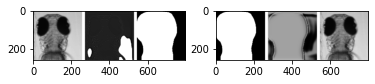

In [68]:
subShow(A2B_val[0,...], B2A_val[0,...])

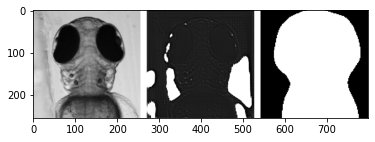

In [69]:
for i in range(A2B_val.shape[0]):
    plt.imshow(A2B_val[i,...], cmap='gray')
    plt.savefig('./cycleGAN/val/A2B/{}.png'.format(i))


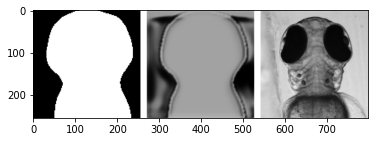

In [70]:
for i in range(B2A_val.shape[0]):
    plt.imshow(B2A_val[i,...], cmap='gray')
    plt.savefig('./cycleGAN/val/B2A/{}.png'.format(i))

#### upload to neptune

#### check for the test dataset

In [ ]:
# 检查当前预测的图像

print(B_generated.shape, A_generated.shape)

NUM = 1
subShow(A_generated[NUM,...], predict_data[1][NUM,...])
subShow(B_generated[NUM,...], predict_data[0][NUM,...])

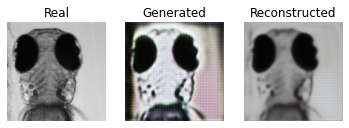

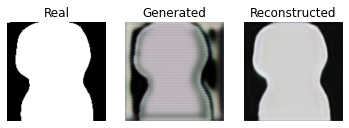

In [41]:
# sanity check for some random images

# plot A->B->A (microscope to masks to microscope)
A_real = select_samples(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

# plot B->A->B (mask to microscope to mask)
B_real = select_samples(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)